open-colleges
Rectangle(xy=(-0.1, 0), width=0.2, height=476, angle=0)
111


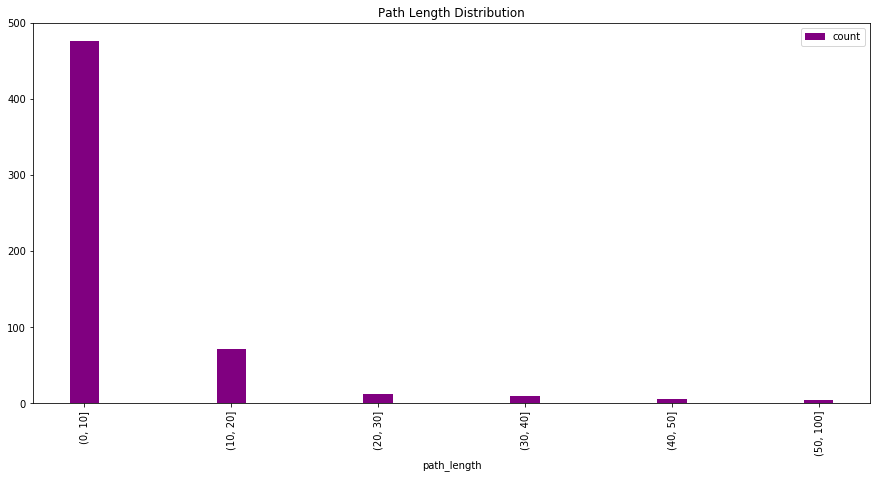

In [1]:
import pandas as pd
from google.cloud import bigquery as bq
import matplotlib as mp
import os
import smtplib
import csv
import sys
import datetime as dt
import sendgrid
import ipdb
import re
from sendgrid.helpers.mail import *
%matplotlib inline
arg_file='/tmp/.args'
Empty_Files={}

def Send_Mail(start_date,end_date,client,message_file):
    with open (message_file,"r+") as fo:
            msg_list=fo.readlines()
    with open('key.env','r+') as fo:
            key=fo.read()
    sg = sendgrid.SendGridAPIClient(key.rstrip('\n'))
    if msg_list:
          message='Below Files are either empty or not created in GBQ for date range\
                   '+start_date+\
                   ' and '  + end_date+"\n"\
                   ' for '+client.upper()+"\n"+'\n'.join(msg_list)
    else:
          message='All files are available with data in date range '+start_date +' and '  + \
                   end_date+"\n"+' for '+client.upper()+"\n"
    data = {
        "personalizations": [
            {
            "to": [{
                    "email": "spillai@datalicious.com"
                }],
            "subject": "Missing or Empty Files"
            }
        ],
        "from": {
            "email": "noreply@optimahub.com"
        },
        "content": [
            {
            "type": "text/plain",
            "value":message
            }
        ]
        }
    sg.client.mail.send.post(request_body=data)

    
       
def Data_Plot(row,df):
    if row['Plot_type']=='pie':
        ax=pd.pivot_table(df, index = 'campaign').plot(kind='pie',y='count'
                                                       ,figsize=(5,5),title=row['Title'])
        ax.set_aspect('equal')
    elif row['Plot_type']=='stack':
        if (df[list(df)[2]] == 0).all():
            print row['Description']+" Files not present to Plot " +row['Title']+"\n"
        else:
            ax=pd.pivot_table(df, index = list(df)[0], columns =list(df)[1], 
                              values =list(df)[2]).plot(kind = 'bar',title=row['Title'],
                                                        width=0.8,figsize=(15,7),stacked=True)
            ax.set_ylabel(list(df)[2],fontsize=16)
    else:
        if (df[list(df)[1]] == 0).all():
            print row['Description']+" Files not present to Plot " +row['Title']+"\n"
        else:
            #ax=pd.pivot_table(df, index = list(df)[0],
                              #values =list(df)[1]).plot(kind = 'bar',title=row['Title'],
                                                      #width=0.2,color='purple',figsize=(15,7)) 
            bins=[0,10,20,30,40,50,100,150,200,250]    
            df['path_length'] = pd.cut(df['path_length'], bins)
            df['count']=df.groupby('path_length')['count'].sum()
            ax=pd.pivot_table(df, index = list(df)[0],
                                values =list(df)[1]).plot(kind = 'bar',title=row['Title'],
                                                    width=0.2,color='purple',figsize=(15,7))
            for i in ax.patches:
                print i
                print '111'
                ax.text(i.get_x()-.03, i.get_height()+.5, \
                    str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                        color='dimgrey')
                print '2222'
            #ax.set_yticklabels(ax.get_yticks())
            ax.set_yscale('log',basey=10)
            ax.set_ylabel(list(df)[1],fontsize=16)
    mp.pyplot.show()
            
            
def Create_Frame(clnt,start_date,end_date,start_date_string,end_date_string):
    print clnt
    client= bq.Client.from_service_account_json('/Users/datalicious/projects/service_account.json')
    fields=[];rows=[]
    with open("Query_check.csv","r")  as fo:
        csvreader = csv.DictReader(fo)
        for row in csvreader:
          row['Query']=row['Query'].format(client=clnt,start_date=start_date,end_date=end_date,
                                           start_date_string=start_date_string,end_date_string=end_date_string)
          try:
            df=client.query(row['Query']).to_dataframe()
            if row['column']=='count': 
                missing_files=df.loc[df[row['column']] == 0]['date']
                Empty_Files[row['Description']]=list(missing_files)
            if df.empty:
                print row['Description']+" Files not present to Plot " +row['Title']+"\n"
                continue
            else:
                Data_Plot(row,df)
          except Exception as e:
            continue
    missing_files={k: v for k, v in Empty_Files.items() if v}
    return missing_files
    
    
def main():
    if os.path.isfile(arg_file):
        with open(arg_file,'r+') as fo:
            args = list(line for line in (val.rstrip() for val in fo) if line)   
        client=args[0]
        start_date=args[1] if len(args)>1 else (dt.datetime.now() 
                                                - dt.timedelta(11)).strftime('%Y-%m-%d')
        end_date=args[2] if len(args)>2  else (dt.datetime.now() 
                                               - dt.timedelta(4)).strftime('%Y-%m-%d')
        start_date_string = re.sub('-', '',start_date)
        end_date_string=re.sub('-','',end_date)        
    Empty_Files=Create_Frame(client,start_date,end_date,start_date_string,end_date_string)
    with open('message',"w+") as fo:
        for k,v in Empty_Files.items():
          fo.write(k+' for below dates '+'\n')
          for val in v:
                fo.write(str(val)+'\n')
    Send_Mail(start_date,end_date,client,'message')
if __name__=="__main__":
    main()